In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import time

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# testing some code

In [12]:
name = '0a148697c.jpg'
labels_file =  "../data/labels/boxes_v2.csv"
path = '../data/'
pimg = 'train_sample/'
pgt = 'train_maps/'

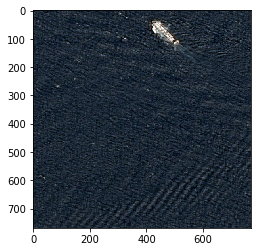

In [13]:
img = mpimg.imread(path + pimg + name)
plt.imshow(img)
plt.show()

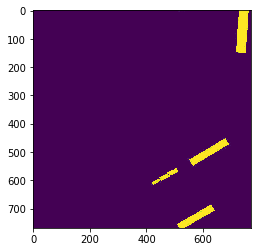

In [4]:
gt = mpimg.imread(path + pgt + "gt_" + name)
plt.imshow(gt)
plt.show()

In [5]:
y_raw = pd.read_csv(labels_file)
y_raw.head(2)

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
0,00003e153.jpg,0,0,0,0,0,0
1,0001124c7.jpg,0,0,0,0,0,0


In [6]:
y_raw[y_raw.ImageId==name]

,ImageId,width,height,lt_x,lt_y,rb_x,rb_y
9180,0a148697c.jpg,26,38,557,473,583,511
9181,0a148697c.jpg,150,44,1,715,151,759
9182,0a148697c.jpg,26,36,575,445,601,481
9183,0a148697c.jpg,82,132,685,507,767,639
9184,0a148697c.jpg,23,30,593,418,616,448
9185,0a148697c.jpg,97,140,451,550,548,690


In [7]:
def get_y_data(y_raw, filename):
    '''
    Converts a filename into an array, with one channel for each boat in the image
    :param filename: filename string
    :return: np array of size [h, w, n_boats_in_this_image]
    '''
    ground_truths = y_raw[y_raw.ImageId == filename]
    array_of_coords = np.array(ground_truths[['lt_x', 'lt_y', 'rb_x', 'rb_y']])
    # array_of_coords is of shape [n_boxes, 4]

    n_boxes = array_of_coords.shape[0]
    y_map = np.zeros((768, 768, n_boxes))

    for box_idx in range(n_boxes):
        # Loop over amount of boats per image ~ of order 10.
        box = array_of_coords[box_idx, :]
        # TODO: check that im using dimensions correctly here and agrees with static file
        y_map[box[0]:box[2], box[1]:box[3], box_idx] = 1

    return y_map

In [8]:
y_map = get_y_data(y_raw,name)
y_map.shape

(768, 768, 6)

In [9]:
y_map = tf.convert_to_tensor(y_map)
y_map = tf.reshape(y_map, [1, 768, 768, 6])

# testing anchor code

In [10]:
import cv2 as cv

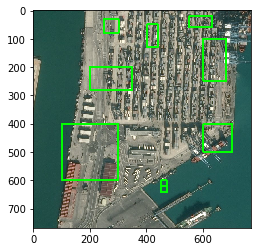

In [14]:
gt = np.copy(img)
gt = cv.rectangle(gt, (450,600), (471,641), (0,255,0), 5) #(21,41)
gt = cv.rectangle(gt, (450,600), (471,621), (0,255,0), 5) #(21,21)
gt = cv.rectangle(gt, (400,50), (441,131), (0,255,0), 5) #(41,81)
gt = cv.rectangle(gt, (550,20), (631,61), (0,255,0), 5) #(81,41)
gt = cv.rectangle(gt, (250,30), (301,81), (0,255,0), 5) #(51,51)
gt = cv.rectangle(gt, (600,400), (700,500), (0,255,0), 5) #(101,101)
gt = cv.rectangle(gt, (200,200), (350,280), (0,255,0), 5) #(151,81)
gt = cv.rectangle(gt, (600,100), (680,250), (0,255,0), 5) #(81, 151)
gt = cv.rectangle(gt, (100,400), (300,600), (0,255,0), 5) # (201,201)
plt.imshow(gt)

In [19]:
# original code
for i, anchor_shape in enumerate(anchor_shapes):
    # Loop over number of anchors ~ of order 9
    # The y_map is of shape [batch_size, h, w, max_n_boats]
    # The kenerl we convolve with is of shape [anchor_shape[0], anchor_shape[1], max_n_boats, max_n_boats]
    # where every entry is 0 except for [:,:, i, i] for all i.
    # (I think) this is equivalent to running a seperate "all ones" [anchor_shape[0], anchor_shape[1], 1]
    # kernel over each of the max_n_boats inputs.
    # TODO: double (triple, quadruple...) check above logic.

    n_box = tf.shape(self.y_map)[-1]
    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box))
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box))
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(self.y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(self.y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)
    max_iou_over_ground_truth = tf.reduce_max(ious, -1)

    tf.summary.scalar(name='max_gt_iou_' + str(i),
                      tensor=tf.reduce_max(max_iou_over_ground_truth))

    summarise_map(name='iou_' + str(i), tensor=max_iou_over_ground_truth)

    labels = tf.greater(max_iou_over_ground_truth, self.config.iou_threshold)
    labels = tf.cast(labels, tf.float32)
    # TODO: test this somehow

    y_class.append(labels)

NameError: name 'self' is not defined

TESTING

In [15]:
anchor_shapes = [(21,21), (21, 41), (41,21), (41, 81), (81, 41), (51,51), (151,81), (81, 151), (101,101), (201,201)]

In [39]:
k = len(anchor_shapes)

In [16]:
i = 0
list_IoU = []
for i, anchor_shape in enumerate(anchor_shapes):
    n_box = tf.shape(y_map)[-1]
    anchor = tf.zeros((anchor_shape[0], anchor_shape[1], n_box, n_box),dtype=tf.float64)
    diagonal = tf.ones((anchor_shape[0], anchor_shape[1], n_box), dtype=tf.float64)
    anchor_area = anchor_shape[0]*anchor_shape[1]

    # Assigns ones to anchor[:,:,i,i] (https://www.tensorflow.org/api_docs/python/tf/linalg/set_diag)
    anchor = tf.linalg.set_diag(anchor, diagonal)

    # Calculates the intersection of anchor with each gt map in y_map simulatenously (as above)
    intersection = tf.nn.conv2d(y_map, anchor, strides=[1, 1, 1, 1], padding='SAME')

    # union is the area of the map (per map layer, and per batch entry) + the anchor area (in 2d)
    # TODO: check that minusing intersection does so entry wise.
    union = tf.reduce_sum(y_map, [1, 2], keepdims=True) + anchor_area - intersection
    ious = tf.divide(intersection, union)
    max_iou_over_ground_truth = tf.reduce_max(ious, -1)
    list_IoU.append(max_iou_over_ground_truth)
    
IoU_matrix = tf.stack(list_IoU, axis=-1)

### let's look at the intersection:

In [40]:
with tf.Session() as sess:
    array = intersection.eval(session=sess)

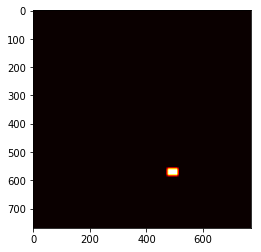

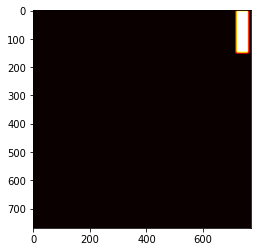

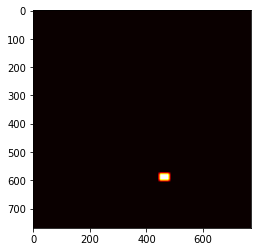

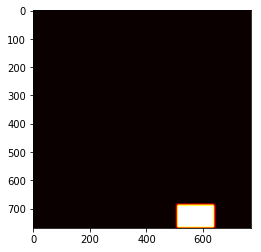

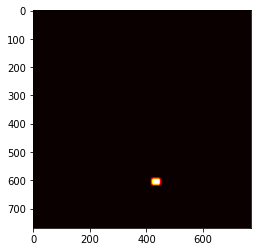

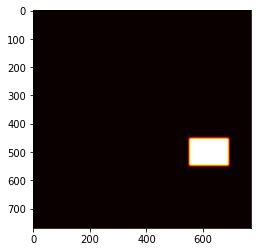

In [45]:
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### let's look at the union

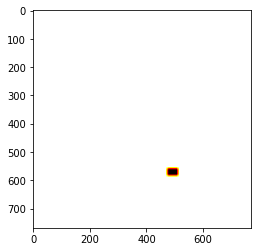

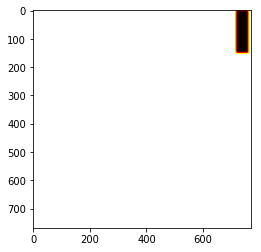

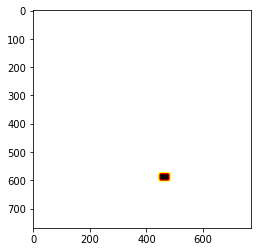

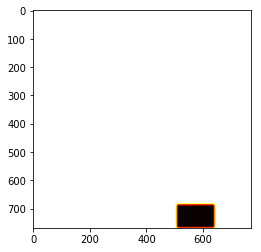

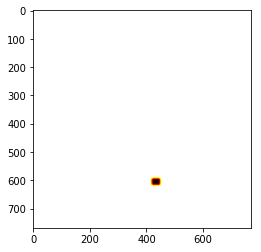

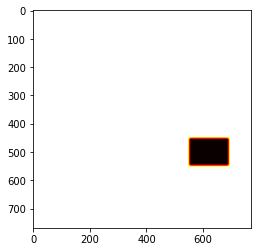

In [72]:
with tf.Session() as sess:
    array = union.eval(session=sess)
for i in range(6):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

### Let's look at IOUs

In [ ]:
### here we calculate the max IOU

In [17]:
tfeval = IoU_matrix
with tf.Session() as sess:
    startTime = time.time()
    array = tfeval.eval(session=sess)
    print("Time: {}".format(time.time() - startTime))

Time: 1645.4670431613922


0.37985390234525185


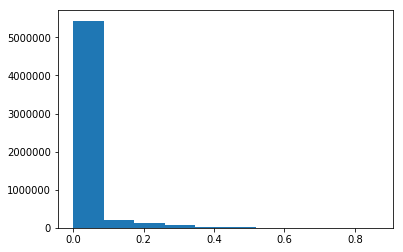

In [18]:
max_iou = np.copy(array)
print(np.max(max_iou[:,:,:,5]))
plt.hist(max_iou.flatten())
plt.show()

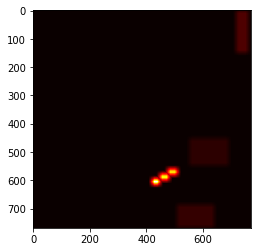

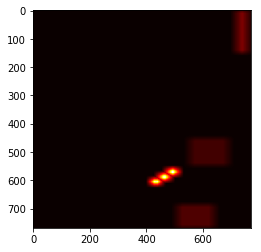

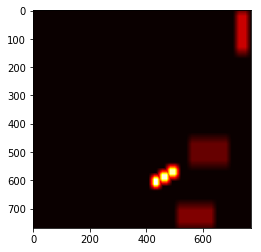

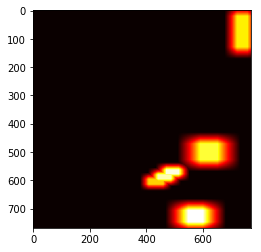

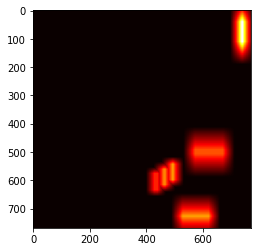

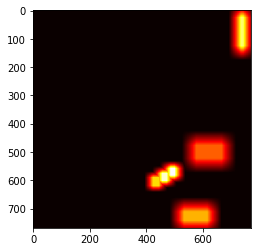

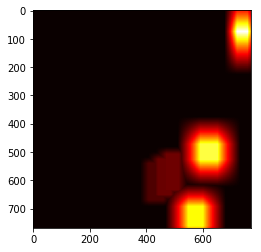

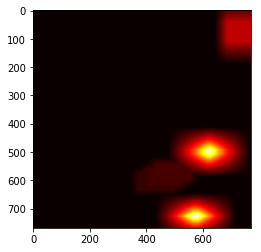

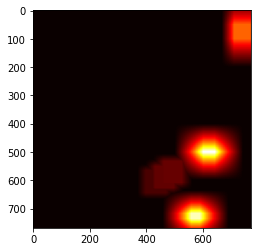

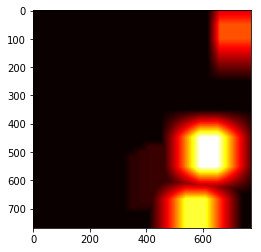

In [19]:
for i in range(10):
    plt.imshow(array[0,:,:,i], cmap='hot', interpolation='nearest')
    plt.show()

In [31]:
np.count_nonzero(array[array < 0.1])

563296

In [32]:
np.count_nonzero(array[array > 0.5])

12446

In [33]:
12446/563296

0.022094955405328638

In [20]:
for i in range(10):
    print(array[:,:,:,i].max())

0.6391304347826087
0.7592768791627021
0.45224719101123595
0.3068181818181818
0.5031818181818182
0.37985390234525185
0.5396124601422615
0.8648386314001456
0.7005863844393593
0.3361302938046088


array should have dimensions [768,768,k], given the centre pixel (x,y) then 
- the top left corner is: [(x - (w-1)/2),(y - (h-1)/2)]
- the bottom right corner is: [(x + (w-1)/2),(y + (h-1)/2)]

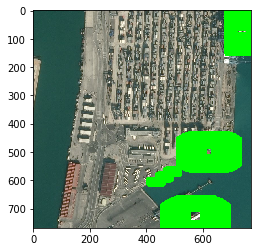

In [25]:
gt = np.copy(img)
a = np.asarray([[21,21], [21, 41], [41,21], [41, 81], [81, 41], [51,51], [151,81], [81, 151], [101,101], [201,201]])
for i in range(array.shape[1]):
    for j in range(array.shape[2]):
        for k in range(array.shape[3]):
            if array[0,i,j,k] > 0.5:
                gt = cv.rectangle(gt,(j - int((a[k,1]-1)/2),i-int((a[k,0]-1)/2)), (j+int((a[k,1]-1)/2),i+int((a[k,0]-1)/2)), (0,255,0), 5)
plt.imshow(gt)
plt.show()

In [44]:
labels = array > 0.5
labels = labels.astype(int)
np.count_nonzero(labels)

12446

In [47]:
labels.shape

(1, 768, 768, 10)

### Matrix mask for resampling

OPTION A

In [82]:
index_1 = np.random.randint(np.count_nonzero(labels), size=(180))
index_1.sort()

In [138]:
startTime = time.time()
maskA = np.zeros(labels.shape)
z = 0
t = 0
count = 0
count_zero = 0
for b in range(mask.shape[0]):
    for i in range(mask.shape[1]):
        for j in range(mask.shape[2]):
            for k in range(mask.shape[3]):
                if labels[b,i,j,k] == 1:
                    count +=1
                    if t < 180 and z == index_1[t]:
                        t += 1
                        maskA[b,i,j,k] = 1
                    z +=1
print(time.time()- startTime)

2.356052875518799


In [80]:
np.count_nonzero(mask)

180

In [81]:
np.count_nonzero(labels)

12446

In [77]:
count

12446

OPTION B

In [179]:
startTime = time.time()
idx1 = np.where(labels == 1)
idx1 = np.asarray(idx1)
index = np.random.randint(idx1.shape[1], size=(180))
a = idx1[:, index]
mask = np.zeros(labels.shape)
mask[a[0], a[1], a[2], a[3]] = 1
print(np.count_nonzero(mask))
print(time.time()-startTime)

178
0.04510807991027832


In [308]:
n_samples = 180
tf_labels = tf.constant(labels)
one = tf.constant(1, dtype= tf.int64)
condition = tf.equal(tf_labels, one)
tf_indices = tf.where(condition)
length_true = tf.shape(tf_indices)[0]
unif_idx = tf.random_uniform([n_samples], maxval=length_true, dtype=tf.int32)
unif_idx = tf.reshape(unif_idx, [n_samples,1])

#idxs = tf.nn.embedding_lookup(tf_indices, unif_idx)
idxs = tf.gather_nd(tf_indices, unif_idx)

tf_mask = tf.Variable(tf.zeros(tf.shape(tf_labels), dtype= tf.int64), dtype= tf.int64)

#tf_mask = tf.scatter_update(tf_mask, [[0,1,2,3,4]], ones)
tf.scatter_update(tf_mask, [0,1,1,1], 
    ref,
    indices,
    updates
#for i in range(n_samples):
#    idx = tf.gather_nd(idxs, [i])
#    tf_mask = tf.assign(tf_mask[idx[0], idx[1], idx[2], idx[3]], one)

init = tf.global_variables_initializer
tfeval = tf_mask
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    a = tfeval.eval(session=sess)

ValueError: Input 'ref' passed int64 expected ref type while building NodeDef 'Variable_61/strided_slice_11328/_assign_Variable_61_0' using Op<name=StridedSliceAssign; signature=ref:Ref(T), begin:Index, end:Index, strides:Index, value:T -> output_ref:Ref(T); attr=T:type; attr=Index:type,allowed=[DT_INT32, DT_INT64]; attr=begin_mask:int,default=0; attr=end_mask:int,default=0; attr=ellipsis_mask:int,default=0; attr=new_axis_mask:int,default=0; attr=shrink_axis_mask:int,default=0>

In [299]:
a

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

In [295]:
labels[0, 515, 605,   7]

1

In [301]:
np.count_nonzero(a)

0

In [202]:
tf.__version__

'1.8.0'

In [180]:
idx1 = np.where(labels == 1)
idx1 = np.asarray(idx1)
idx1

array([[  0,   0,   0, ...,   0,   0,   0],
       [ 41,  41,  41, ..., 748, 748, 748],
       [735, 736, 737, ..., 581, 582, 583],
       [  4,   4,   4, ...,   7,   7,   7]])

In [161]:
labels[0,41,736,4]

1

In [162]:
idx1.shape

(4, 12446)

In [106]:
index = np.random.randint(idx1.shape[1], size=(180))
index.sort()
index

array([    9,    69,   142,   197,   239,   305,   446,   504,   532,
         571,   573,   731,   738,   774,   795,   806,   845,   868,
        1040,  1179,  1495,  1537,  1651,  1767,  1769,  1771,  1797,
        1844,  1918,  2013,  2030,  2331,  2358,  2376,  2379,  2389,
        2453,  2456,  2546,  2559,  2568,  2658,  2681,  2693,  2844,
        2937,  2962,  2986,  3097,  3112,  3136,  3169,  3278,  3359,
        3502,  3571,  3584,  3687,  3717,  3757,  4058,  4084,  4121,
        4569,  4588,  4647,  4651,  4690,  4747,  4886,  4932,  5011,
        5071,  5152,  5177,  5196,  5215,  5215,  5347,  5359,  5403,
        5406,  5436,  5509,  5704,  5716,  5723,  5799,  5845,  6191,
        6214,  6247,  6272,  6367,  6588,  6590,  6745,  6755,  6812,
        6831,  6892,  6997,  7022,  7099,  7157,  7171,  7190,  7213,
        7299,  7367,  7373,  7507,  7555,  7596,  7642,  7844,  7879,
        7908,  7928,  8073,  8086,  8101,  8121,  8253,  8292,  8370,
        8436,  8476,

In [135]:
a = idx1[:, index]
a[3]

array([4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 7, 8, 7, 7,
       7, 8, 8, 8, 8, 7, 8, 7, 8, 8, 7, 7, 8, 8, 8, 7, 7, 8, 7, 8, 7, 7,
       7, 7, 8, 8, 8, 7, 7, 8, 8, 8, 7, 8, 7, 8, 8, 8, 7, 7, 7, 7, 7, 8,
       8, 7, 7, 7, 7, 7, 8, 7, 8, 7, 8, 8, 7, 7, 7, 8, 8, 7, 7, 7, 8, 7,
       7, 8, 7, 8, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 7, 8,
       8, 8, 8, 8, 8, 7, 8, 7, 7, 8, 7, 8, 8, 7, 8, 8, 7, 7, 8, 8, 7, 8,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 7, 8, 7, 8, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 7, 7, 7, 8, 8, 8, 7, 7, 7, 7, 8, 7, 8, 7, 7, 7, 8, 8, 7, 7, 7,
       7, 7, 8, 8])

In [155]:
np.count_nonzero(mask)

180

In [16]:
a = np.asarray([1,2])
a.dtype

dtype('int64')